# Data loading

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

california_dataset = fetch_california_housing()
x_train, x_test, y_train, y_test = train_test_split(california_dataset.data, california_dataset.target, test_size=0.2, random_state=42)

# Linear regression with gradient descent
## Model training

Running on cuda


Training: 100%|██████████| 10000/10000 [02:27<00:00, 67.99it/s]


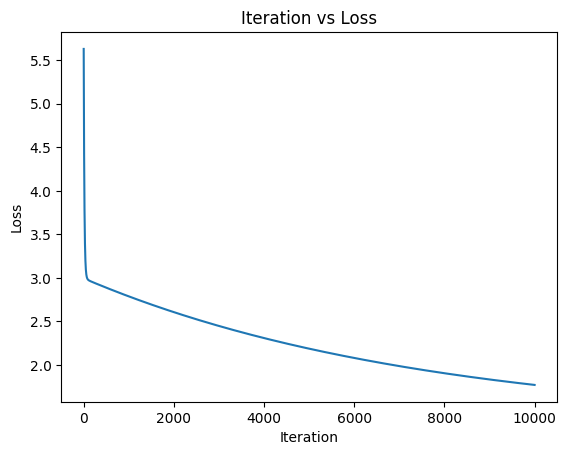

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from linear_regression import LinearRegressionGradientDescent

# Select the device to run the code on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print (f'Running on {device}')

iterations = 10000
learning_rate = 10e-9
model = LinearRegressionGradientDescent(torch.Tensor(x_train), torch.Tensor(y_train), learning_rate, device)
training_history = {}

for iteration in tqdm(range(iterations), desc="Training"):
    loss = model.step()
    
    loss_value = loss.cpu().numpy().item()
    bias = model.bias.cpu().detach()
    weights = model.weights.cpu().detach()
    training_history[iteration] = (loss_value, bias, weights)

plt.xlabel("Iteration")
plt.title("Iteration vs Loss")
plt.ylabel("Loss")
plt.plot(np.arange(iterations), [training_history[i][0] for i in range(iterations)])

## Model visualization over iterations

In [3]:
# Plot the results
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

def plot_predictions(iteration_index, random_indices, var_index, x_test, y_test, weights, bias) -> None:
    x_test = x_test[random_indices]
    y_test = y_test[random_indices]
    y_predicted = (torch.matmul(x_test, weights) + bias).flatten()

    # For plotting
    x_min = x_test[:,var_index].min() - 1
    x_max = x_test[:,var_index].max() + 1
    y_min = y_test.min() - 1
    y_max = y_test.max() + 1

    # Calculate the MSE
    mse = torch.mean(torch.square(y_test - y_predicted))

    # Clean everything
    plt.clf()
    plt.xlabel(california_dataset.feature_names[var_index])
    plt.ylabel(california_dataset.target_names[0])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.scatter(x_test[:,var_index].cpu().numpy(), y_test.cpu().numpy()) # Plot test data
    plt.scatter(x_test[:,var_index].cpu().numpy(), y_predicted.cpu().numpy(), color="k") # Plot predictions
    plt.title(f"Iteration {iteration_index} - MSE: {mse:.2f}")

def animate(frame_index: int) -> None:
    iteration_index = iterations_schedule[frame_index]
    _, bias, weights = training_history[iteration_index]
    plot_predictions(iteration_index, random_indices, variable_index, x_test, y_test, weights, bias)

# Data to plot
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

num_points_to_display = 100
variable_index = 0

num_iterations_to_display = 1000
# Generate a linear schedule for the iterations to display
iterations_schedule = np.linspace(0, iterations - 1, num_iterations_to_display, dtype=np.int32)

np.random.seed(42)

# Select random indices to display over time
random_indices = np.random.choice(x_test.shape[0], num_points_to_display)

fig = plt.figure()
anim = FuncAnimation(fig, animate, init_func=None, frames=num_iterations_to_display, interval=200, blit=False)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()